LeNet、AlexNet和VGG都有一个共同的设计模式：通过一系列的卷积层与汇聚层来提取空间结构特征；然后通过全连接层对特征的表征进行处理。 AlexNet和VGG对LeNet的改进主要在于如何扩大和加深这两个模块。 或者，可以想象在这个过程的早期使用全连接层。然而，如果使用了全连接层，可能会完全放弃表征的空间结构。 网络中的网络（NiN）提供了一个非常简单的解决方案：在每个像素的通道上分别使用多层感知机 

回想一下，卷积层的输入和输出由四维张量组成，张量的每个轴分别对应样本、通道、高度和宽度。 <br>
另外，全连接层的输入和输出通常是分别对应于样本和特征的二维张量。

NiN的想法是在每个像素位置（针对每个高度和宽度）应用一个全连接层。 如果我们将权重连接到每个空间位置，我们可以将其视为卷积层（如 6.4节中所述），或作为在每个像素位置上独立作用的全连接层。 <br>
从另一个角度看，即将空间维度中的每个像素视为单个样本，将通道维度视为不同特征（feature）。

图7.3.1说明了VGG和NiN及它们的块之间主要架构差异。 NiN块以一个普通卷积层开始，后面是两个1x1的卷积层。这两个卷积层充当带有ReLU激活函数的逐像素全连接层。 第一层的卷积窗口形状通常由用户设置。 随后的卷积窗口形状固定为1x1。

1×1卷积允许在保持空间维度的同时，在通道维度上进行非线性组合；同时通过在传统卷积后添加多个1×1卷积层，大幅增强了模型的非线性表达能力

再回顾下卷积层是对每个通道利用卷积核后对输出结构进行求和，因此对于1x1卷积核来说得到的是该位置上多个通道元素的线性组合

全局平均池化替代全连接层：
- 消除全连接层：传统CNN在卷积层后使用全连接层进行分类，参数量巨大
- 全局平均池化：NiN直接将最后特征图的每个通道平均池化为一个值，然后直接用于分类
- 显著减少参数量：全连接层通常占据CNN大部分参数，全局平均池化几乎没有参数
- 也可以看作是一种结构化正则化手段来减少过拟合

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

最初的NiN网络是在AlexNet后不久提出的，显然从中得到了一些启示。 NiN使用窗口形状为11x11、5x5和3x3的卷积层，输出通道数量与AlexNet中的相同。 每个NiN块后有一个最大汇聚层，汇聚窗口形状为3x3，步幅为2。

NiN和AlexNet之间的一个显著区别是NiN完全取消了全连接层。 相反，NiN在该部分再次使用一个3x3的NiN块，其输出通道数等于标签类别的数量。最后放一个全局平均汇聚层（global average pooling layer），生成一个对数几率 （logits）。NiN设计的一个优点是，它显著减少了模型所需参数的数量。然而，在实践中，这种设计有时会增加训练模型的时间。

In [2]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten()
)

创建数据样本来查看输出

In [3]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


训练模型

loss 0.376, train acc 0.860, test acc 0.859
379.4 examples/sec on cuda:0


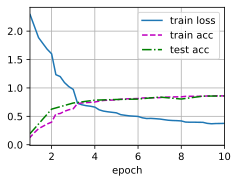

In [4]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())